<a href="https://colab.research.google.com/github/soaresbru/WorldCup2022Prediction/blob/main/Previs%C3%A3o_Copa_do_Mundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copa do Mundo: Previsão dos resultados dos jogos

Neste notebook serão realizadas as principais etapas para desenvolver um modelo que prevê os resultados dos jogos da fase de grupos da Copa do Mundo do Catar 2022

A motivação desse projeto tem o desafio World Cup's Data Science Contest, oferecido pela SigmaGeek.  
Se você quiser participar de outros desafios entre no link:  
https://sigmageek.com/?ref=04QS0KSQ7V8J9VH

## Conteúdo
1. Importando as bibliotecas
2. Leitura das bases consumidas
3. Olhando brevemente os dados
4. Engenharia de variáveis
5. Trabalhando apenas com os dados da Copa - "Treino é treino, e jogo é jogo"
6. Dividindo em treino, validação e teste.
7. Engenharia de variáveis com os dados da Copa
8. Treinando o modelo - RandomForestClassifier
9. Treinando o modelo - XGBClassifier
10. Treinando o modelo - LogisticRegression
11. Treinando o arquivo de teste para o submissão
12. Criando o arquivo para submissão

## 1. Importando as bibliotecas

Nesta etapa, todas as biliotecas usadas no notebook serão importadas



In [ ]:
# Importando as bibliotecas padrões
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Biblioteca padrão para trabalhar com datas
from datetime import datetime

# Importando a biblioteca para carregar arquivos do drive
from google.colab import drive

# Importando as bibliotecas de modelo
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

# Importandoa as bibliotecas de métricas
from sklearn.metrics import  accuracy_score
from sklearn.metrics import classification_report

In [ ]:
# Montando o Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Leitura das bases consumidas
Nesta etapa a base de dados será lida, o arquivo "international_matches.csv", foi encontrado no Kaggle.  
https://www.kaggle.com/datasets/brenda89/fifa-world-cup-2022  

Já o arquivo Fase de grupos eu mesmo que criei inserindo os dados do ranking da fifa, e colocando o score de cada time com base no arquivo "international_matches.csv".  

Para indicar que as lesões estavam afetando as seleções, criei uma espécie "punição", a seleções da frança principalmente pela perda de Benzema e Kanté( -2 pontos no score de ataque, -2 no score do meio de campo e -1 no score da defesa) e senegal que perdeu Mané (-2 ponto no ataque).



In [ ]:
# Caminho para pegar os arquivos do drive
caminho = '/content/drive/MyDrive/Dataset - projetos dados/Copa do mundo 2022/international_matches.csv'
fase_grupos = '/content/drive/MyDrive/Dataset - projetos dados/Copa do mundo 2022/Fase_de_grupos.csv'

In [ ]:
df_copa= pd.read_csv(caminho, delimiter=';')
df_copa_2022 = pd.read_csv(fase_grupos, delimiter=';')

## 3. Olhando brevemente os dados




In [ ]:
# OLhando as primeiras linhas
df_copa.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,08/08/1993,Bolivia,Uruguay,South America,South America,59.0,22.0,0.0,0.0,3.0,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,08/08/1993,Brazil,Mexico,South America,North America,8.0,14.0,0.0,0.0,1.0,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,08/08/1993,Ecuador,Venezuela,South America,South America,35.0,94.0,0.0,0.0,5.0,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,08/08/1993,Guinea,Sierra Leone,Africa,Africa,65.0,86.0,0.0,0.0,1.0,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,08/08/1993,Paraguay,Argentina,South America,South America,67.0,5.0,0.0,0.0,1.0,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Olhando o tipo de cada coluna
df_copa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23969 entries, 0 to 23968
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           23969 non-null  object 
 1   home_team                      23969 non-null  object 
 2   away_team                      23969 non-null  object 
 3   home_team_continent            23921 non-null  object 
 4   away_team_continent            23921 non-null  object 
 5   home_team_fifa_rank            23923 non-null  float64
 6   away_team_fifa_rank            23922 non-null  float64
 7   home_team_total_fifa_points    23921 non-null  float64
 8   away_team_total_fifa_points    23921 non-null  float64
 9   home_team_score                23921 non-null  float64
 10  away_team_score                23921 non-null  float64
 11  tournament                     23921 non-null  object 
 12  city                           23921 non-null 

In [ ]:
# Transformando a coluna data de object to datetime
df_copa['date'] = pd.to_datetime(df_copa['date'])

In [ ]:
# Olhando os valores nulos
df_copa.isnull().sum().sort_values(ascending=False)

away_team_mean_defense_score     16405
home_team_mean_defense_score     16182
away_team_mean_midfield_score    15990
away_team_goalkeeper_score       15873
home_team_mean_midfield_score    15807
away_team_mean_offense_score     15657
home_team_goalkeeper_score       15588
home_team_mean_offense_score     15459
country                             48
home_team_result                    48
shoot_out                           48
city                                48
tournament                          48
away_team_score                     48
home_team_score                     48
away_team_total_fifa_points         48
home_team_total_fifa_points         48
away_team_continent                 48
home_team_continent                 48
away_team_fifa_rank                 47
home_team_fifa_rank                 46
home_team                            0
neutral_location                     0
away_team                            0
date                                 0
dtype: int64

In [ ]:
# OLhando a quantidade de cada resultado, vemos que a maioria dos jogos não acaba em empate
df_copa['home_team_result'].value_counts().sort_values(ascending=False)

Win     11761
Lose     6771
Draw     5389
Name: home_team_result, dtype: int64

In [ ]:
# Criando uma função para mudar os valores categóricos de resultado para numérico. 
def transform_resultado(result):
  if result == "Win":
    return 1
  elif result == "Lose":
    return -1
  else:
    return 0
df_copa['home_team_result'] = df_copa['home_team_result'].map(transform_resultado)

## 4. Engenharia de variáveis
Nesta etapa vamos criar novas variáveis e eliminar outras



In [ ]:
# Criando uma variável que junta o score da ataque (midfield + offense) e depois junta o score da defesa (goalkeeper + defense)
df_copa['home_attack'] = df_copa['home_team_mean_midfield_score'] + df_copa['home_team_mean_offense_score']
df_copa['home_defense'] = df_copa['home_team_goalkeeper_score'] + df_copa['home_team_mean_defense_score']

df_copa['away_attack'] = df_copa['away_team_mean_midfield_score'] + df_copa['away_team_mean_offense_score']
df_copa['away_defense'] = df_copa['away_team_goalkeeper_score'] + df_copa['away_team_mean_defense_score']

# Aplicando no arquivo df_copa_2022 também
df_copa_2022['home_attack'] = df_copa_2022['home_team_mean_midfield_score'] + df_copa_2022['home_team_mean_offense_score']
df_copa_2022['home_defense'] = df_copa_2022['home_team_goalkeeper_score'] + df_copa_2022['home_team_mean_defense_score']

df_copa_2022['away_attack'] = df_copa_2022['away_team_mean_midfield_score'] + df_copa_2022['away_team_mean_offense_score']
df_copa_2022['away_defense'] = df_copa_2022['away_team_goalkeeper_score'] + df_copa_2022['away_team_mean_defense_score']

In [ ]:
# Criando uma variável com o ranking do time da casa menos do time de fora
df_copa['rank_difference'] = df_copa['home_team_fifa_rank'] - df_copa['away_team_fifa_rank']

df_copa_2022['rank_difference'] = df_copa_2022['home_team_fifa_rank'] - df_copa_2022['away_team_fifa_rank']

In [ ]:
# Vamos apagar as colunas que no primeiro momento não são muito importantes

# Não importa a cidade ou pais, o mais importante é saber se a localização é neutra ou não
# Como só queremos saber a fase de grupos o shoot_out não é importante

df_copa = df_copa.drop(['home_team_continent', 'away_team_continent', 'city','country', 
              'shoot_out', 'home_team_mean_midfield_score', 'home_team_mean_offense_score', 
              'home_team_goalkeeper_score', 'home_team_mean_defense_score', 
              'away_team_mean_midfield_score', 'away_team_mean_offense_score', 
              'away_team_goalkeeper_score',  'away_team_mean_defense_score'], axis=1)

## 5. Trabalhando apenas com os dados da Copa - "Treino é treino, e jogo é jogo"
Nesta etapa, observamos que tínhamos muitos dados faltantes antes de 2005, então vamos usar dados de 2006 em diante.




In [ ]:
df_copa = df_copa[df_copa['tournament']== 'FIFA World Cup']

In [ ]:
# A maioria dos empates da copa termina 1x1
numero_empates = df_copa[df_copa['home_team_result']== 0]
numero_empates['home_team_score'].value_counts().sort_values(ascending=False)

1.0    35
0.0    24
2.0    19
3.0     2
Name: home_team_score, dtype: int64

In [ ]:
# A maioria dos times derrotados em casa não marca gol
numero_derrotas = df_copa[df_copa['home_team_result']== -1]
numero_derrotas['home_team_score'].value_counts().sort_values(ascending=False)

0.0    86
1.0    47
2.0    13
Name: home_team_score, dtype: int64

In [ ]:
# A maioria dos times vitoriosos em casa vence com 2 gols
numero_derrotas = df_copa[df_copa['home_team_result']== 1]
numero_derrotas['home_team_score'].value_counts().sort_values(ascending=False)

2.0    79
1.0    57
3.0    39
4.0    16
0.0     5
6.0     4
5.0     4
8.0     1
7.0     1
Name: home_team_score, dtype: int64

In [ ]:
# Criando uma Baseline pelo ranking da copa, o time com melhor posição no ranking vence

def transform_baseline(base):
  if base > 0:
    return -1
  else:
    return 1
df_copa['vitoria_baseline'] = df_copa['rank_difference'].map(transform_baseline)

In [ ]:
# Então no baseline tem uma acurácia de Acc: 0.5648
acc1 = accuracy_score(y_true=df_copa['home_team_result'], y_pred=df_copa['vitoria_baseline'])
print('Acc: {:.4f}'.format(acc1))

Acc: 0.5648


## 6. Dividindo em treino, validação e teste.
Para realizar a predição escolhi fazer uma especie de janela de expansão:
- Vou usar o dado de 2006 para prever 2010. 
- Os dados de 2006 + 2010 para prever 2014. 
- Os dados de 2006 + 2010 + 2014 para prever 2018. 
- E por fim os dados de 2006 + 2010 + 2014 + 2018 para prever 2022.


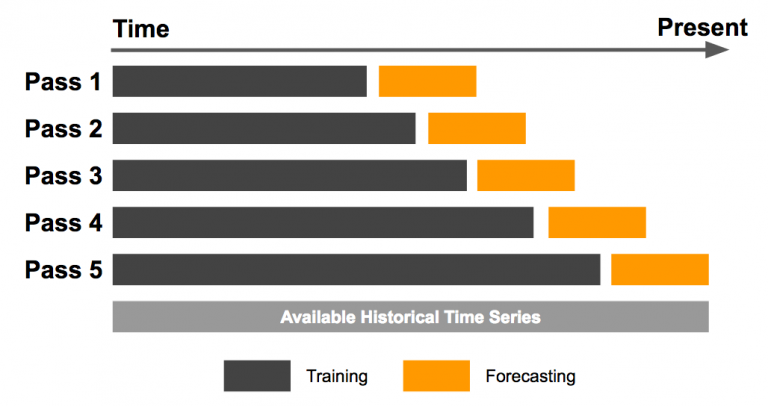

https://stackoverflow.com/questions/45370666/what-are-pandas-expanding-window-functions

In [ ]:
copa_2006 = df_copa[df_copa['date'].dt.year ==2006]
copa_2010 = df_copa[df_copa['date'].dt.year ==2010]
copa_2014 = df_copa[df_copa['date'].dt.year ==2014]
copa_2018 = df_copa[df_copa['date'].dt.year ==2018]
copa_2022 = df_copa_2022

In [ ]:
# Selecionando apenas os dados das fases de grupo pois é o que queremos prever.
copa_2006= copa_2006[:48]
copa_2010 = copa_2010[:48]
copa_2014 = copa_2014[:48]
copa_2018 = copa_2018[:48]
copa_2022 = copa_2022[:48]

In [ ]:
treino = copa_2006
valid_1 = copa_2010
valid_2 = copa_2014
valid_3 =copa_2018
teste = copa_2022

## 7. Engenharia de variáveis com os dados da Copa



In [ ]:
# Preenchendo as variáveis nulas (estes geralmente de seleções com menos tradição), com os menores scores

treino['away_defense'] = treino['away_defense'].fillna(treino['away_defense'].min())
treino['home_defense'] = treino['home_defense'].fillna(treino['home_defense'].min())
treino['home_attack'] = treino['home_attack'].fillna(treino['home_attack'].min())
treino['away_attack'] = treino['away_attack'].fillna(treino['away_attack'].min())

valid_1['away_defense'] = valid_1['away_defense'].fillna(valid_1['away_defense'].min())
valid_1['home_defense'] = valid_1['home_defense'].fillna(valid_1['home_defense'].min())
valid_1['home_attack'] = valid_1['home_attack'].fillna(valid_1['home_attack'].min())
valid_1['away_attack'] = valid_1['away_attack'].fillna(valid_1['away_attack'].min())

valid_2['away_defense'] = valid_2['away_defense'].fillna(valid_2['away_defense'].min())
valid_2['home_defense'] = valid_2['home_defense'].fillna(valid_2['home_defense'].min())
valid_2['home_attack'] = valid_2['home_attack'].fillna(valid_2['home_attack'].min())
valid_2['away_attack'] = valid_2['away_attack'].fillna(valid_2['away_attack'].min())

valid_3['away_defense'] = valid_3['away_defense'].fillna(valid_3['away_defense'].min())
valid_3['home_defense'] = valid_3['home_defense'].fillna(valid_3['home_defense'].min())
valid_3['home_attack'] = valid_3['home_attack'].fillna(valid_3['home_attack'].min())
valid_3['away_attack'] = valid_3['away_attack'].fillna(valid_3['away_attack'].min())

teste['away_defense'] = teste['away_defense'].fillna(teste['away_defense'].min())
teste['home_defense'] = teste['home_defense'].fillna(teste['home_defense'].min())
teste['home_attack'] = teste['home_attack'].fillna(teste['home_attack'].min())
teste['away_attack'] = teste['away_attack'].fillna(teste['away_attack'].min())

In [ ]:
# Criando variável pensando no ataque menos defesa
treino['home_attack_goal'] = treino['home_attack'] - treino['away_defense']
treino['away_attack_goal'] = treino['away_attack'] - treino['home_defense']

valid_1['home_attack_goal'] = valid_1['home_attack'] - valid_1['away_defense']
valid_1['away_attack_goal'] = valid_1['away_attack'] - valid_1['home_defense']

valid_2['home_attack_goal'] = valid_2['home_attack'] - valid_2['away_defense']
valid_2['away_attack_goal'] = valid_2['away_attack'] - valid_2['home_defense']

valid_3['home_attack_goal'] = valid_3['home_attack'] - valid_3['away_defense']
valid_3['away_attack_goal'] = valid_3['away_attack'] - valid_3['home_defense']

teste['home_attack_goal'] = teste['home_attack'] - teste['away_defense']
teste['away_attack_goal'] = teste['away_attack'] - teste['home_defense']

In [ ]:
# Criando variável com praticamente um normalização da variável anterior
treino['diff_goal'] = (treino['home_attack_goal'] - treino['away_attack_goal'])/treino['home_attack_goal']

valid_1['diff_goal'] = (valid_1['home_attack_goal'] - valid_1['away_attack_goal'])/valid_1['home_attack_goal']

valid_2['diff_goal'] = (valid_2['home_attack_goal'] - valid_2['away_attack_goal'])/valid_2['home_attack_goal']

valid_3['diff_goal'] = (valid_3['home_attack_goal'] - valid_3['away_attack_goal'])/valid_3['home_attack_goal']

teste['diff_goal'] = (teste['home_attack_goal'] - teste['away_attack_goal'])/teste['home_attack_goal']

In [ ]:
# O score do time é a some dos scores de ataque e defesa
treino['home_score'] = treino['home_attack'] + treino['home_defense']
treino['away_score'] = treino['away_attack'] + treino['away_defense']

valid_1['home_score'] = valid_1['home_attack'] + valid_1['home_defense']
valid_1['away_score'] = valid_1['away_attack'] + valid_1['away_defense']

valid_2['home_score'] = valid_2['home_attack'] + valid_2['home_defense']
valid_2['away_score'] = valid_2['away_attack'] + valid_2['away_defense']

valid_3['home_score'] = valid_3['home_attack'] + valid_3['home_defense']
valid_3['away_score'] = valid_3['away_attack'] + valid_3['away_defense']

teste['home_score'] = teste['home_attack'] + teste['home_defense']
teste['away_score'] = teste['away_attack'] + teste['away_defense']

In [ ]:
# Criando variável com praticamente um normalização da variável anterior
treino['dif_fifa_rank'] = (treino['home_team_fifa_rank'] - treino['away_team_fifa_rank'])/treino['home_team_fifa_rank'] 

valid_1['dif_fifa_rank'] = (valid_1['home_team_fifa_rank'] - valid_1['away_team_fifa_rank'])/valid_1['home_team_fifa_rank']

valid_2['dif_fifa_rank'] = (valid_2['home_team_fifa_rank'] - valid_2['away_team_fifa_rank'])/valid_2['home_team_fifa_rank']

valid_3['dif_fifa_rank'] = (valid_3['home_team_fifa_rank'] - valid_3['away_team_fifa_rank'])/valid_3['home_team_fifa_rank']

teste['dif_fifa_rank'] = (teste['home_team_fifa_rank'] - teste['away_team_fifa_rank'])/teste['home_team_fifa_rank']

In [ ]:
#xvariaveis = ['home_team_fifa_rank',	'away_team_fifa_rank', 'home_attack',	'home_defense',	'away_attack',	'away_defense', 'rank_difference', 'home_attack_goal', 'away_attack_goal', 'diff_goal', 'home_score','away_score' ]

In [ ]:
# Selecionando as variaveis do modelo
xvariaveis = ['rank_difference', 'home_attack_goal', 'away_attack_goal', 'diff_goal', 'home_score','away_score' ]

In [ ]:
# Separando Variável X e y
y_treino = treino['home_team_result']
X_treino= treino[xvariaveis]

y_valid_1 = valid_1['home_team_result']
X_valid_1= valid_1[xvariaveis]

y_valid_2 = valid_2['home_team_result']
X_valid_2= valid_2[xvariaveis]

y_valid_3 = valid_3['home_team_result']
X_valid_3= valid_3[xvariaveis]

y_teste = teste['home_team_result']
X_teste= teste[xvariaveis]

In [ ]:
# Criando o dado de treino com o dado de treino anterior + validação anterior
y_treino_2 = pd.concat([y_treino, y_valid_1], axis=0)
X_treino_2 = pd.concat([X_treino, X_valid_1], axis=0)

y_treino_3 = pd.concat([y_treino_2, y_valid_2], axis=0)
X_treino_3 = pd.concat([X_treino_2, X_valid_2], axis=0)

y_treino_4 = pd.concat([y_treino_3, y_valid_3], axis=0)
X_treino_4 = pd.concat([X_treino_3, X_valid_3], axis=0)

In [ ]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_treino = scaler.fit_transform(X_treino, columns= xvariaveis)
#X_treino = pd.DataFrame(X_treino)
#X_valid1 = scaler.fit_transform(X_valid)
#X_valid1 = pd.DataFrame(X_valid, columns = xvariaveis)

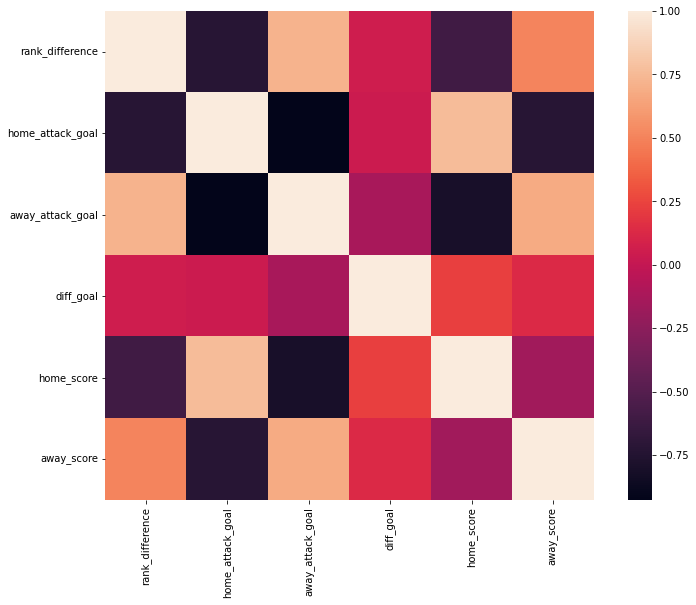

In [ ]:
# OLhando se as variavéis são correlacioandas
corrmat = X_treino.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

## 8. Treinando o modelo - RandomForestClassifier
Nesta etapa, vamos de fato treinar o modelo, lembrando da nossa janela de expansão:
- Vou usar o dado de 2006 para prever 2010. 
- Os dados de 2006 + 2010 para prever 2014. 
- Os dados de 2006 + 2010 + 2014 para prever 2018. 
- E por fim os dados de 2006 + 2010 + 2014 + 2018 para prever 2022.

Isso através da RandomForestClassifier, XGBClassifier e LogisticRegression.  
  
Começando pela RandomForestClassifier


In [ ]:
modelo = RandomForestClassifier(n_estimators=200, min_samples_leaf= 2, max_depth= 6, n_jobs=-1, random_state=0)
modelo.fit(X_treino, y_treino)
p1 = modelo.predict(X_valid_1)

acc1 = accuracy_score(y_true=y_valid_1, y_pred=p1)
print('Acc: {:.4f}'.format(acc1))

# matriz de confusão
print(classification_report(y_valid_1, p1))

Acc: 0.4583


In [ ]:
modelo = RandomForestClassifier(n_estimators=200, min_samples_leaf= 2, max_depth= 6, n_jobs=-1, random_state=0)
modelo.fit(X_treino_2, y_treino_2)
p2 = modelo.predict(X_valid_2)

acc2 = accuracy_score(y_true=y_valid_2, y_pred=p2)
print('Acc: {:.4f}'.format(acc2))

# matriz de confusão
print(classification_report(y_valid_2, p2))

Acc: 0.5417


In [ ]:
modelo = RandomForestClassifier(n_estimators=200, min_samples_leaf= 2, max_depth= 6, n_jobs=-1, random_state=0)
modelo.fit(X_treino_3, y_treino_3)
p3 = modelo.predict(X_valid_3)

acc3 = accuracy_score(y_true=y_valid_3, y_pred=p3)
print('Acc: {:.4f}'.format(acc3))

# matriz de confusão
print(classification_report(y_valid_3, p3))

              precision    recall  f1-score   support

          -1       0.59      0.53      0.56        19
           0       0.25      0.11      0.15         9
           1       0.56      0.75      0.64        20

    accuracy                           0.54        48
   macro avg       0.46      0.46      0.45        48
weighted avg       0.51      0.54      0.51        48



In [ ]:
media = (acc1 + acc2 +acc3)/3
print(media)

0.5347222222222222


## 9. Treinando o modelo - XGBClassifier



In [ ]:
modelo = xgb.XGBClassifier(random_state=0,
                          n_estimators=100,use_label_encoder=False)
modelo.fit(X_treino, y_treino)
p1 = modelo.predict(X_valid_1)

acc1 = accuracy_score(y_true=y_valid_1, y_pred=p1)
print('Acc: {:.4f}'.format(acc1))

# matriz de confusão
print(classification_report(y_valid_1, p1))

Acc: 0.4583


In [ ]:
modelo = xgb.XGBClassifier(random_state=0,
                          n_estimators=100,use_label_encoder=False)
modelo.fit(X_treino_2, y_treino_2)
p2 = modelo.predict(X_valid_2)

acc2 = accuracy_score(y_true=y_valid_2, y_pred=p2)
print('Acc: {:.4f}'.format(acc2))

# matriz de confusão
print(classification_report(y_valid_2, p2))

Acc: 0.5417


In [ ]:
modelo = xgb.XGBClassifier(random_state=0,
                          n_estimators=100,use_label_encoder=False)
modelo.fit(X_treino_3, y_treino_3)
p3 = modelo.predict(X_valid_3)

acc3 = accuracy_score(y_true=y_valid_3, y_pred=p3)
print('Acc: {:.4f}'.format(acc3))

# matriz de confusão
print(classification_report(y_valid_3, p3))

              precision    recall  f1-score   support

          -1       0.59      0.53      0.56        19
           0       0.25      0.11      0.15         9
           1       0.56      0.75      0.64        20

    accuracy                           0.54        48
   macro avg       0.46      0.46      0.45        48
weighted avg       0.51      0.54      0.51        48



In [ ]:
media = (acc1 + acc2 +acc3)/3
print(media)

0.5347222222222222


## 10. Treinando o modelo - LogisticRegression



In [ ]:
modelo = LogisticRegression(C=10)
modelo.fit(X_treino, y_treino)
p1 = modelo.predict(X_valid_1)

acc1 = accuracy_score(y_true=y_valid_1, y_pred=p1)
print('Acc: {:.4f}'.format(acc1))

# matriz de confusão
print(classification_report(y_valid_1, p1))

Acc: 0.4583


In [ ]:
modelo = LogisticRegression(C=10)
modelo.fit(X_treino_2, y_treino_2)
p2 = modelo.predict(X_valid_2)

acc2 = accuracy_score(y_true=y_valid_2, y_pred=p2)
print('Acc: {:.4f}'.format(acc2))

# matriz de confusão
print(classification_report(y_valid_2, p2))

Acc: 0.5417


In [ ]:
modelo = LogisticRegression(C=10)
modelo.fit(X_treino_3, y_treino_3)
p3 = modelo.predict(X_valid_3)

acc3 = accuracy_score(y_true=y_valid_3, y_pred=p3)
print('Acc: {:.4f}'.format(acc3))

# matriz de confusão
print(classification_report(y_valid_3, p3))

Acc: 0.6458


In [ ]:
# Este modelo ficou muito bom, foi melhorando ao longo do tempo com o número crescente de dados
# Vamos ver como está nossa baseline para essa copa do mundo e se conseguimos bater a baseline
def transform_baseline(base):
  if base > 0:
    return -1
  else:
    return 1
baseline_y3 = X_valid_3['rank_difference'].map(transform_baseline)

acc3 = accuracy_score(y_true=y_valid_3, y_pred=baseline_y3)
print('Acc: {:.4f}'.format(acc3))

Acc: 0.5417


In [ ]:
media = (acc1 + acc2 +acc3)/3
print(media)

0.5347222222222222


## 11. Treinando o arquivo de teste para o submissão



In [ ]:
modelo = LogisticRegression(C=10)
modelo.fit(X_treino_4, y_treino_4)

p= modelo.predict_proba(teste[xvariaveis].fillna(-1))

In [ ]:
# Olhando os jogos da Copa 
teste

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,home_defense,away_attack,away_defense,rank_difference,home_attack_goal,away_attack_goal,diff_goal,home_score,away_score,dif_fifa_rank
0,20/11/2022,Qatar,Ecuador,NaN,NaN,50,44,NaN,NaN,NaN,...,142.0,150.5,144.5,6,-5.0,8.5,2.700000,281.5,295.0,0.120000
1,21/11/2022,Senegal,Netherlands,NaN,NaN,18,8,NaN,NaN,NaN,...,162.0,172.0,168.0,10,-10.3,10.0,1.970874,319.7,340.0,0.555556
2,21/11/2022,England,Iran,NaN,NaN,5,20,NaN,NaN,NaN,...,168.0,144.3,142.0,-15,30.0,-23.7,1.790000,340.0,286.3,-3.000000
3,21/11/2022,United States,Wales,NaN,NaN,16,19,NaN,NaN,NaN,...,152.8,151.5,149.0,-3,4.5,-1.3,1.288889,306.3,300.5,-0.187500
4,22/11/2022,France,Australia,NaN,NaN,4,38,NaN,NaN,NaN,...,170.2,145.8,149.0,-34,21.1,-24.4,2.156398,340.3,294.8,-8.500000
5,22/11/2022,Denmark,Tunisia,NaN,NaN,10,30,NaN,NaN,NaN,...,165.2,146.3,142.0,-20,15.9,-18.9,2.188679,323.1,288.3,-2.000000
6,22/11/2022,Mexico,Poland,NaN,NaN,13,26,NaN,NaN,NaN,...,156.8,160.5,162.2,-13,-1.3,3.7,3.846154,317.7,322.7,-1.000000
7,22/11/2022,Argentina,Saudi Arabia,NaN,NaN,3,51,NaN,NaN,NaN,...,166.2,140.5,142.8,-48,30.2,-25.7,1.850993,339.2,283.3,-16.000000
8,23/11/2022,Belgium,Canada,NaN,NaN,2,41,NaN,NaN,NaN,...,169.8,151.0,145.2,-39,26.0,-18.8,1.723077,341.0,296.2,-19.500000
9,23/11/2022,Spain,Costa Rica,NaN,NaN,7,31,NaN,NaN,NaN,...,170.5,139.5,159.5,-24,11.5,-31.0,3.695652,341.5,299.0,-3.428571


In [ ]:
# Olhando a probabilidade de cada jogo
p

array([[0.4995839 , 0.25425109, 0.24616501],
       [0.55586193, 0.25124443, 0.19289363],
       [0.113962  , 0.14392837, 0.74210964],
       [0.36234544, 0.26414737, 0.37350719],
       [0.13926546, 0.22661271, 0.63412183],
       [0.19507532, 0.23381755, 0.57110713],
       [0.41988221, 0.28625273, 0.29386506],
       [0.08930418, 0.19710484, 0.71359098],
       [0.12498826, 0.21452733, 0.66048441],
       [0.18540058, 0.24699371, 0.56760571],
       [0.16015761, 0.18067847, 0.65916392],
       [0.43013134, 0.26336089, 0.30650777],
       [0.22990145, 0.28291044, 0.48718812],
       [0.23719624, 0.23029635, 0.53250741],
       [0.14826503, 0.28660474, 0.56513023],
       [0.21973167, 0.23936882, 0.5408995 ],
       [0.31393741, 0.23661901, 0.44944359],
       [0.69213118, 0.20252155, 0.10534727],
       [0.15346783, 0.23845331, 0.60807886],
       [0.20085094, 0.20033761, 0.59881145],
       [0.42647655, 0.29440398, 0.27911946],
       [0.17071223, 0.2317781 , 0.59750967],
       [0.

## 12. Criando o arquivo para submissão



Criando uma regra para definir os placares dos jogos:
- Se a probabilidade for maior de empate, então vai 1x1, pois é o placar mais comum de empate na copa.
- Se um time tiver a probalidade de ganhar maior que 0.7, então vai ser 3x0.
- Se um time tiver a probalidade de ganhar maior que 0.6, então vai ser 2x0.
- Se um time tiver a probalidade de ganhar menor que 0.6, então vai ser 1x0.

In [ ]:
placar = []
for i in range(0,len(p)):
  if (p[i][1]> p[i][0]) and (p[i][1]> p[i][2]):
      game='1x1'
  elif p[i][0]> p[i][2]:
    if p[i][2]<0.4:
      home='0'
      if (p[i][0])*10>7:
        visitor='3'
      elif (p[i][0])*10>6:
        visitor='2'
      else:
        visitor='1'
      game=home+'x'+visitor
  else:
    if p[i][0]<0.4:
      visitor='0'
      if (p[i][2])*10>7:
        home='3'
      elif (p[i][2])*10>6:
        home='2'
      else:
        home='1'
      game=home+'x'+visitor
  placar.append(game)

In [ ]:
placar

['0x1',
 '0x1',
 '3x0',
 '1x0',
 '2x0',
 '1x0',
 '0x1',
 '3x0',
 '2x0',
 '1x0',
 '2x0',
 '0x1',
 '1x0',
 '1x0',
 '1x0',
 '1x0',
 '1x0',
 '0x2',
 '2x0',
 '1x0',
 '0x1',
 '1x0',
 '1x0',
 '1x0',
 '0x1',
 '1x0',
 '1x0',
 '0x1',
 '0x1',
 '1x1',
 '1x0',
 '1x0',
 '0x2',
 '0x1',
 '0x2',
 '2x0',
 '0x2',
 '0x3',
 '0x1',
 '0x2',
 '0x1',
 '0x1',
 '0x2',
 '0x2',
 '0x2',
 '0x2',
 '0x1',
 '0x3']

In [ ]:
sub = pd.Series(placar)

In [ ]:
# Criando o arquivo csv para enviar
sub.to_csv('copasigma.csv', header= False, index=None)

In [ ]:
# OLhando as primeiras linhas do arquivo
!head -n10 copasigma.csv

0x1
0x1
3x0
1x0
2x0
1x0
0x1
3x0
2x0
1x0


## Obrigado por chegar até aqui.  
  
  
### Se tiver qualquer dúvida ou sugestão por favor entre em contato comigo